# Решающее дерево

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score


pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

Для основных распределений датасета, см. `l1.ipynb`

In [89]:
path = "dataset/horse.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## Бейзлайн: решающее дерево без подбора гиперпараметров

### Бейзлайн датасет

In [90]:
X = df.drop(columns=["outcome"])
y = df["outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Тренериуем бейзлайн

In [91]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

categorical_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    [("num", "passthrough", num_cols), ("cat", categorical_pipe, cat_cols)]
)

dectree_base = DecisionTreeClassifier(random_state=228)
model_base = Pipeline([("preprocess", preprocess), ("clf", dectree_base)])
model_base.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Оценка бейзлайна на тестовой выборке

In [92]:
y_pred = model_base.predict(X_test)
y_pred_proba = model_base.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred)
f1_base = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", acc_base)
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.55

Classification report:
               precision    recall  f1-score   support

        died       0.39      0.47      0.42        15
  euthanized       0.38      0.33      0.35         9
       lived       0.68      0.64      0.66        36

    accuracy                           0.55        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.56      0.55      0.55        60



### Тепловая карта confusion matrix

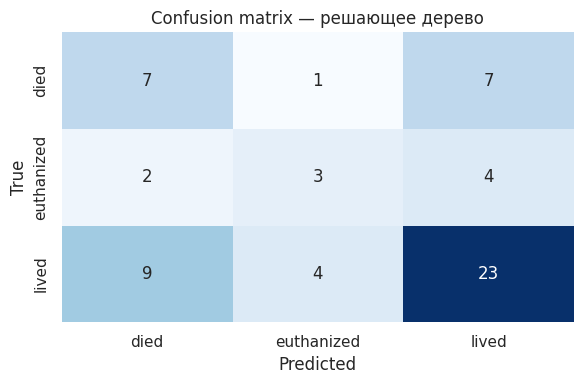

In [93]:
cm = confusion_matrix(y_test, y_pred, labels=model_base.classes_)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=axes,
)
axes.set_xlabel("Predicted")
axes.set_ylabel("True")
axes.set_title("Confusion matrix — решающее дерево")

plt.tight_layout()
plt.show()


## Улучшение бейзлайна для решающего дерева
1. Сделать gridsearch с подбором параметров решающего дерева
2. Использовать class_weight для учета дисбаланса классов
3. Попробовать разные критерии и ограничения глубины дерева
4. Использовать метрику f1_macro для многоклассовой классификации

### Подготовка улучшенного датасета


In [94]:
df_imp = df.copy()

X_imp = df_imp.drop(columns=["outcome"])
y_imp = df_imp["outcome"]

cat_cols_imp = X_imp.select_dtypes(include=["object"]).columns.tolist()
num_cols_imp = [c for c in X_imp.columns if c not in cat_cols_imp]

print(
    f"\nОсталось признаков: {X_imp.shape[1]} ({len(num_cols_imp)} числовых, {len(cat_cols_imp)} категориальных)"
)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)



Осталось признаков: 27 (11 числовых, 16 категориальных)


### Подбор гиперпараметров для решающего дерева


In [95]:
numeric_pipe_imp = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe_imp = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess_imp = ColumnTransformer(
    [
        ("num", numeric_pipe_imp, num_cols_imp),
        ("cat", categorical_pipe_imp, cat_cols_imp),
    ]
)

dectree_imp = DecisionTreeClassifier(random_state=1337)

model_imp = Pipeline([("preprocess", preprocess_imp), ("clf", dectree_imp)])

param_grid_imp = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [3, 5, 7, 10, 15, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4, 8],
    "clf__class_weight": [None, "balanced"],
}

print("\nЗапуск GridSearchCV для подбора гиперпараметров...")
print(
    f"Количество комбинаций: {len(param_grid_imp['clf__criterion']) * len(param_grid_imp['clf__max_depth']) * len(param_grid_imp['clf__min_samples_split']) * len(param_grid_imp['clf__min_samples_leaf']) * len(param_grid_imp['clf__class_weight'])}"
)

gs_imp = GridSearchCV(
    model_imp, param_grid_imp, cv=5, scoring="f1_macro", n_jobs=-1, verbose=1
)

gs_imp.fit(X_train_imp, y_train_imp)

print(f"Лучший f1_macro (кросс-валидация): {gs_imp.best_score_:.4f}")
print(f"Лучшие параметры: {gs_imp.best_params_}")

best_model_imp = gs_imp.best_estimator_



Запуск GridSearchCV для подбора гиперпараметров...
Количество комбинаций: 288
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Лучший f1_macro (кросс-валидация): 0.6321
Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}


### Оценка улучшенной модели на тестовой выборке


In [96]:
y_pred_imp = best_model_imp.predict(X_test_imp)
y_pred_proba_imp = best_model_imp.predict_proba(X_test_imp)

acc_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average="macro")

print(f"Accuracy: {acc_imp:.4f}")
print(f"F1-macro: {f1_imp:.4f}")
print("\nClassification report (3 класса):")
print(classification_report(y_test_imp, y_pred_imp))


auc_scores = {}
for i, class_label in enumerate(best_model_imp.classes_):
    auc = roc_auc_score((y_test_imp == class_label).astype(int), y_pred_proba_imp[:, i])
    auc_scores[class_label] = auc
print("\nAUC-ROC (One-vs-Rest):")
for class_label, auc in auc_scores.items():
    print(f"  Класс {class_label}: {auc:.4f}")
print(f"  Средний AUC: {np.mean(list(auc_scores.values())):.4f}")


Accuracy: 0.5000
F1-macro: 0.4379

Classification report (3 класса):
              precision    recall  f1-score   support

        died       0.41      0.47      0.44        15
  euthanized       0.21      0.33      0.26         9
       lived       0.69      0.56      0.62        36

    accuracy                           0.50        60
   macro avg       0.44      0.45      0.44        60
weighted avg       0.55      0.50      0.52        60


AUC-ROC (One-vs-Rest):
  Класс died: 0.6815
  Класс euthanized: 0.6340
  Класс lived: 0.5596
  Средний AUC: 0.6250


### Визуализация результатов


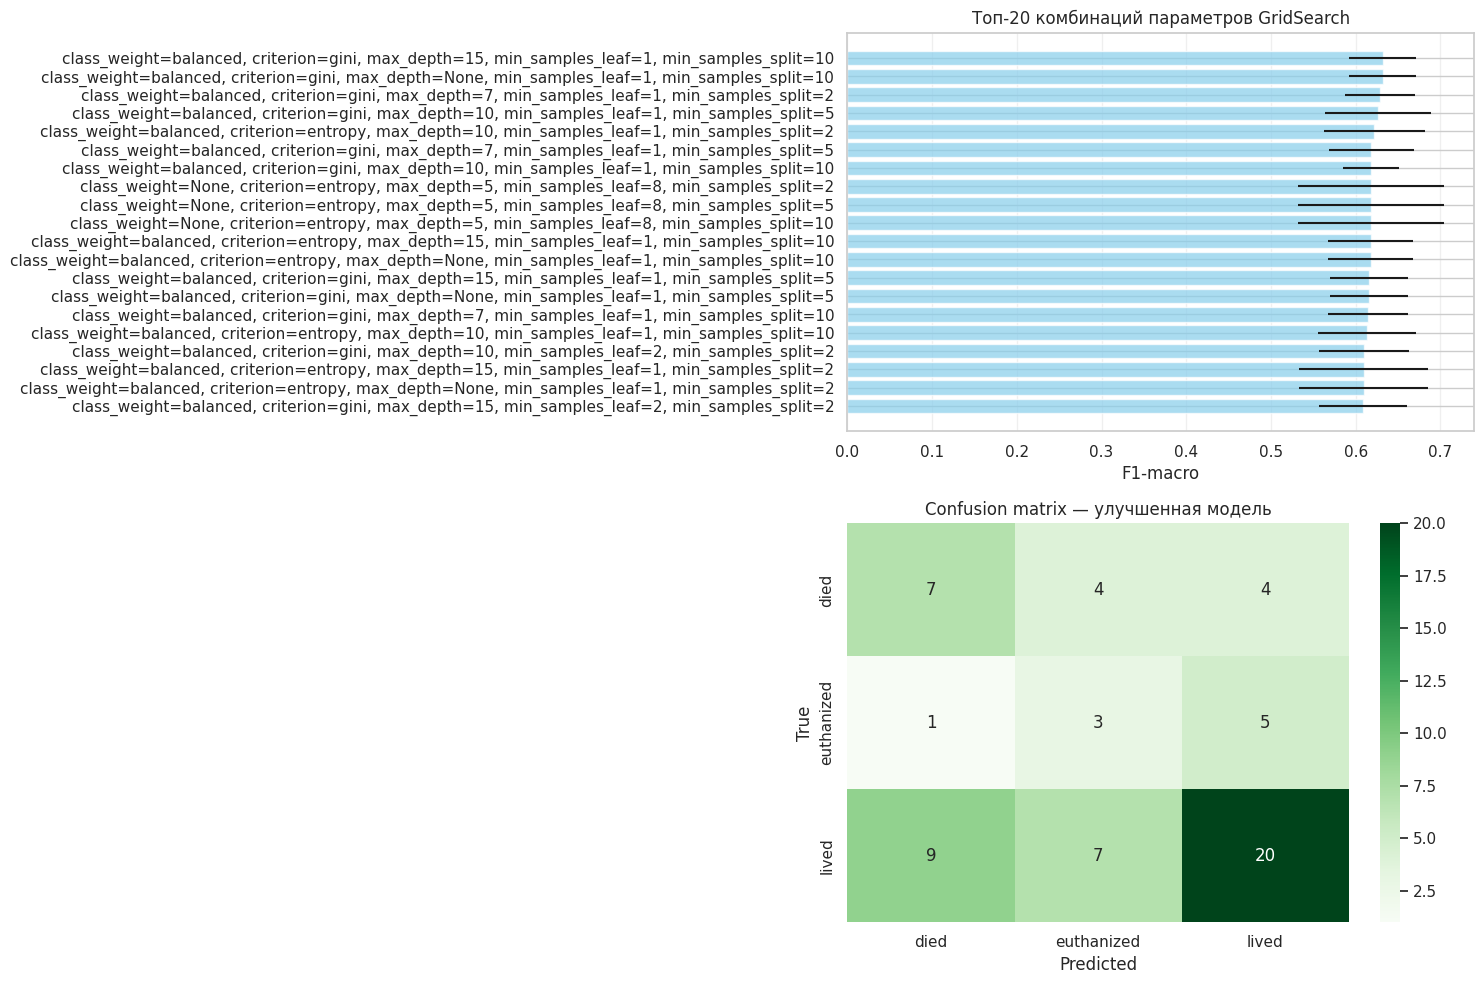


Результаты GridSearch:
   - Лучшая конфигурация: {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
   - Лучший F1-macro (CV): 0.6321

Производительность на тесте:
   - Accuracy: 0.5000
   - F1-macro: 0.4379

Улучшение по сравнению с бейзлайном:
   - Accuracy: +-9.1%
   - F1-macro: +-8.4%


In [97]:
fig, axes = plt.subplots(2, figsize=(15, 10))

cv_res_imp = pd.DataFrame(gs_imp.cv_results_)

top_results = cv_res_imp.nsmallest(20, "rank_test_score")[
    ["params", "mean_test_score", "std_test_score"]
].copy()


def params_to_str(params_dict):
    return ", ".join([f"{k.split('__')[-1]}={v}" for k, v in params_dict.items()])


top_results["params_str"] = top_results["params"].apply(params_to_str)

axes[0].barh(
    range(len(top_results)),
    top_results["mean_test_score"],
    xerr=top_results["std_test_score"],
    alpha=0.7,
    color="skyblue",
)
axes[0].set_yticks(range(len(top_results)))
axes[0].set_yticklabels(top_results["params_str"])
axes[0].set_xlabel("F1-macro")
axes[0].set_title("Топ-20 комбинаций параметров GridSearch")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis="x")

cm_imp = confusion_matrix(y_test_imp, y_pred_imp, labels=best_model_imp.classes_)
sns.heatmap(
    cm_imp,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    xticklabels=best_model_imp.classes_,
    yticklabels=best_model_imp.classes_,
    ax=axes[1],
)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion matrix — улучшенная модель")

plt.tight_layout()
plt.show()


print("\nРезультаты GridSearch:")
print(f"   - Лучшая конфигурация: {gs_imp.best_params_}")
print(f"   - Лучший F1-macro (CV): {gs_imp.best_score_:.4f}")

print("\nПроизводительность на тесте:")
print(f"   - Accuracy: {acc_imp:.4f}")
print(f"   - F1-macro: {f1_imp:.4f}")

improvement_acc = (acc_imp - acc_base) / acc_base * 100
improvement_f1 = (f1_imp - f1_base) / f1_base * 100
print("\nУлучшение по сравнению с бейзлайном:")
print(f"   - Accuracy: +{improvement_acc:.1f}%")
print(f"   - F1-macro: +{improvement_f1:.1f}%")

## Собственная имплементация DecisionTree


In [98]:
class CustomDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion="gini",
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.random_state = random_state

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - np.sum(probabilities**2)

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _information_gain(self, y, y_left, y_right):
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)

        if self.criterion == "gini":
            parent_impurity = self._gini(y)
            left_impurity = self._gini(y_left)
            right_impurity = self._gini(y_right)
        else:
            parent_impurity = self._entropy(y)
            left_impurity = self._entropy(y_left)
            right_impurity = self._entropy(y_right)

        return parent_impurity - (
            n_left / n * left_impurity + n_right / n * right_impurity
        )

    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]

            unique_values = np.unique(feature_values)

            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2

                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                if (
                    len(y[left_mask]) < self.min_samples_leaf
                    or len(y[right_mask]) < self.min_samples_leaf
                ):
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _create_leaf_node(self, y, n_samples):
        class_counts = {}
        for cls in self.classes_:
            class_counts[cls] = np.sum(y == cls)
        total = sum(class_counts.values())
        probabilities = {cls: count / total for cls, count in class_counts.items()}
        predicted_class = max(class_counts, key=class_counts.get)

        return {
            "type": "leaf",
            "class": predicted_class,
            "probabilities": probabilities,
            "samples": n_samples,
        }

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        unique_classes = np.unique(y)

        if (
            (self.max_depth is not None and depth >= self.max_depth)
            or n_samples < self.min_samples_split
            or len(unique_classes) == 1
        ):
            return self._create_leaf_node(y, n_samples)

        best_feature, best_threshold, best_gain = self._find_best_split(X, y)

        if best_feature is None or best_gain < 1e-10:
            return self._create_leaf_node(y, n_samples)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            "type": "node",
            "feature": best_feature,
            "threshold": best_threshold,
            "gain": best_gain,
            "left": left_subtree,
            "right": right_subtree,
            "samples": n_samples,
        }

    def fit(self, X, y):
        if self.random_state is not None:
            random.seed(self.random_state)
            np.random.seed(self.random_state)

        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self.tree_ = self._build_tree(X, y)
        self.n_nodes_ = self._count_nodes(self.tree_)

        return self

    def _count_nodes(self, node):
        if node["type"] == "leaf":
            return 1
        return 1 + self._count_nodes(node["left"]) + self._count_nodes(node["right"])

    def _predict_sample(self, x, node):
        if node["type"] == "leaf":
            return node["class"], node["probabilities"]

        if x[node["feature"]] <= node["threshold"]:
            return self._predict_sample(x, node["left"])
        else:
            return self._predict_sample(x, node["right"])

    def predict(self, X):
        X = np.asarray(X)
        predictions = []
        for sample in X:
            pred_class, _ = self._predict_sample(sample, self.tree_)
            predictions.append(pred_class)
        return np.array(predictions)

    def predict_proba(self, X):
        X = np.asarray(X)
        probabilities = []
        for sample in X:
            _, probs = self._predict_sample(sample, self.tree_)
            prob_array = [probs.get(cls, 0) for cls in self.classes_]
            probabilities.append(prob_array)
        return np.array(probabilities)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

Применяем собственный DecisionTree на исходных данных.


In [99]:
preprocess.fit(X_train)
X_train_base_t = preprocess.transform(X_train)
X_test_base_t = preprocess.transform(X_test)

dectree_custom = CustomDecisionTree(max_depth=5, random_state=42)
dectree_custom.fit(X_train_base_t, y_train)
y_pred_custom = dectree_custom.predict(X_test_base_t)


In [100]:
acc_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average="macro")

print("Custom DecTree Accuracy (base data):", acc_custom)
print("Custom DecTree F1-macro (base data):", f1_custom)
print("\nClassification report:\n", classification_report(y_test, y_pred_custom))


Custom DecTree Accuracy (base data): 0.43333333333333335
Custom DecTree F1-macro (base data): 0.37985739750445635

Classification report:
               precision    recall  f1-score   support

        died       0.26      0.33      0.29        15
  euthanized       0.27      0.33      0.30         9
       lived       0.60      0.50      0.55        36

    accuracy                           0.43        60
   macro avg       0.38      0.39      0.38        60
weighted avg       0.47      0.43      0.45        60



Confusion matrtix для собственного бейзлайна

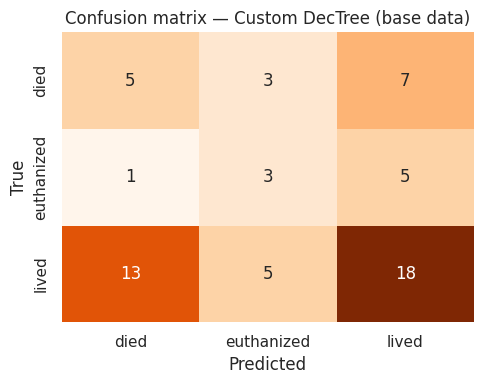

In [101]:
cm_custom = confusion_matrix(y_test, y_pred_custom, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom,
    annot=True,
    fmt="d",
    cmap="Oranges",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom DecTree (base data)")
plt.tight_layout()
plt.show()


Custom DecTree на улучшенных данных (используем лучшие параметры из GridSearch).

In [102]:
preprocess_imp.fit(X_train_imp)
X_train_imp_t = preprocess_imp.transform(X_train_imp)
X_test_imp_t = preprocess_imp.transform(X_test_imp)

best_C = gs_imp.best_params_.get("clf__C", 1.0)
best_penalty = gs_imp.best_params_.get("clf__penalty", "l2")

best_criterion = gs_imp.best_params_.get("clf__criterion", "gini")
best_max_depth = gs_imp.best_params_.get("clf__max_depth", 10)
best_min_samples_split = gs_imp.best_params_.get("clf__min_samples_split", 2)
best_min_samples_leaf = gs_imp.best_params_.get("clf__min_samples_leaf", 1)

custom_dectree_imp = CustomDecisionTree(
    criterion=best_criterion,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12,
)

custom_dectree_imp.fit(X_train_imp_t, y_train_imp)
y_pred_custom_imp = custom_dectree_imp.predict(X_test_imp_t)

acc_custom_imp = accuracy_score(y_test_imp, y_pred_custom_imp)
f1_custom_imp = f1_score(y_test_imp, y_pred_custom_imp, average="macro")

print("Custom DecTree (improved) Accuracy:", acc_custom_imp)
print("Custom DecTree (improved) F1-macro:", f1_custom_imp)

Custom DecTree (improved) Accuracy: 0.6
Custom DecTree (improved) F1-macro: 0.5283126293995859


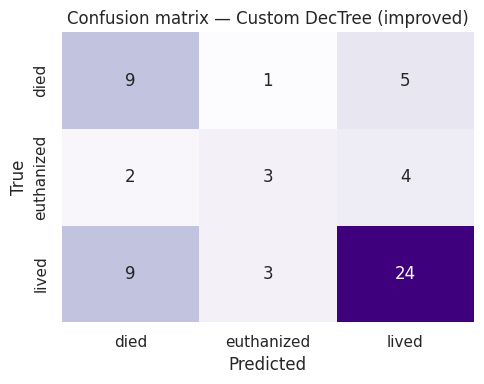

In [103]:
cm_custom_imp = confusion_matrix(y_test_imp, y_pred_custom_imp, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom_imp,
    annot=True,
    fmt="d",
    cmap="Purples",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom DecTree (improved)")
plt.tight_layout()
plt.show()

In [104]:
summary_base = pd.DataFrame(
    {
        "model": ["Бейзлайн (sklearn DecTree)", "Custom DecTree (base data)"],
        "accuracy": [acc_base, acc_custom],
        "f1_macro": [f1_base, f1_custom],
    }
)
print("Сравнение с бейзлайном:\n", summary_base, sep="")

summary_improved = pd.DataFrame(
    {
        "model": ["Улучшенный бейзлайн", "Custom DecTree (improved)"],
        "accuracy": [acc_imp, acc_custom_imp],
        "f1_macro": [f1_imp, f1_custom_imp],
    }
)
print("\nСравнение с улучшенными данными:\n", summary_improved, sep="")

summary_all = pd.DataFrame(
    {
        "model": [
            "Бейзлайн (sklearn DecTree)",
            "Custom DecTree (base data)",
            "Улучшенный бейзлайн",
            "Custom DecTree (improved)",
        ],
        "accuracy": [acc_base, acc_custom, acc_imp, acc_custom_imp],
        "f1_macro": [f1_base, f1_custom, f1_imp, f1_custom_imp],
    }
)
print("\nВсе модели:\n", summary_all, sep="")

Сравнение с бейзлайном:
                        model  accuracy  f1_macro
0  Бейзлайн (sklearn DecTree)  0.550000  0.478109
1  Custom DecTree (base data)  0.433333  0.379857

Сравнение с улучшенными данными:
                       model  accuracy  f1_macro
0        Улучшенный бейзлайн       0.5  0.437918
1  Custom DecTree (improved)       0.6  0.528313

Все модели:
                        model  accuracy  f1_macro
0  Бейзлайн (sklearn DecTree)  0.550000  0.478109
1  Custom DecTree (base data)  0.433333  0.379857
2         Улучшенный бейзлайн  0.500000  0.437918
3   Custom DecTree (improved)  0.600000  0.528313


1. Значительное улучшение после предобработки данных:
   - Кастомное дерево на улучшенных данных показало наилучший результат: Accuracy 60% и F1-macro 52.8%
   - Это на 16.7 процентных пункта выше по Accuracy и на 14.9 п.п. выше по F1-macro по сравнению с кастомным деревом на исходных данных

2. Кастомная реализация превзошла sklearn на улучшенных данных:
   - На улучшенных данных кастомное дерево превзошло sklearn версию на 10 п.п. по Accuracy и на 9 п.п. по F1-macro
   - Однако на исходных данных sklearn модель оказалась стабильнее (Accuracy 55% против 43.3%)

3. Различное влияние предобработки на модели:
   - Удаление признаков с пропусками улучшило кастомную модель (+16.7% Accuracy)
   - Но ухудшило sklearn модель (-5% Accuracy), что указывает на:
     * Либо потерю информативных признаков
     * Либо лучшую обработку пропусков в sklearn реализации
     * Либо переобучение кастомной модели на очищенных данных

4. Стабильность vs. потенциальная производительность:
   - Sklearn DecisionTree демонстрирует более стабильную работу "из коробки"
   - Кастомная реализация требует тщательной настройки, но при правильной предобработке может показывать лучшие результаты

Кастомная реализация Decision Tree, после тщательной предобработки данных, показала лучший результат (Accuracy 60%), превзойдя sklearn реализацию на 10%. Однако sklearn модель продемонстрировала большую стабильность на исходных данных, что указывает на ее лучшую устойчивость к необработанным данным.

# Регрессия с помощью решающего дерева

In [105]:
path_reg = "dataset/Employee_Complete_Dataset.csv"
reg_df = pd.read_csv(path_reg)
print(reg_df.shape)
reg_df.head()

(50000, 19)


,Employee_number,Employee_name,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,performance_rating,Education_level,Department,Role,Job_Satisfaction,Work_Life_Balance,is_outlier
0,10001,Karen Anderson,36,True,116138,2,12,6,1,No,Yes,Yes,3,Bachelor's,R&D,Researcher,10.000000,1.936454,0
1,10002,David Taylor,34,False,82171,3,10,5,0,Yes,Yes,No,5,Diploma,HR,HR Executive,10.000000,4.077728,0
2,10003,Nina Kumar,36,False,48600,1,0,2,3,Yes,Yes,Yes,4,Diploma,Sales,Sales Manager,10.000000,3.975622,0
3,10004,John Patel,42,True,39675,1,2,4,2,Yes,Yes,Yes,3,Diploma,Engineering,Software Engineer,1.000000,3.790951,0
4,10005,Emily Sharma,27,True,161304,3,3,11,2,Yes,Yes,Yes,2,High School,R&D,Scientist,8.251833,10.000000,0


## Бейзлайн

Заведем датасет для бейзлайн модели

In [106]:
df_base = reg_df.copy()

X_base = df_base.drop(
    columns=[
        "Current_Salary",
        "Employee_number",
        "Employee_name",
        "is_outlier",
        "Divorced_earlier",
        "Father_alive",
        "Mother_alive",
        "Maritial_Status",
        "Role",
        "Education_level",
        "Department",
    ]
)
y_base = df_base["Current_Salary"]

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=52
)

## Бейзлайн модель

In [107]:
model = DecisionTreeRegressor(random_state=52)
model.fit(X_train_base, y_train_base)

y_pred_base = model.predict(X_test_base)

base_mae = mean_absolute_error(y_test_base, y_pred_base)
base_rmse = np.sqrt(mean_squared_error(y_test_base, y_pred_base))
base_r2 = r2_score(y_test_base, y_pred_base)

print(f"MAE: {base_mae:.2f}")
print(f"RMSE: {base_rmse:.2f}")
print(f"R2: {base_r2:.4f}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

MAE: 27198.02
RMSE: 42273.95
R2: -0.8952
Количество признаков: 27
Размер обучающей выборки: 239
Размер тестовой выборки: 60


## Улучшенная модель:
- с подбором гиперпараметров
- c чищенным датасетом

Заведем почищенный датасет

In [108]:
numeric_features = [
    "Employee_age",
    "Number_of_Children",
    "years_experience",
    "past_projects",
    "current_projects",
    "performance_rating",
    "Job_Satisfaction",
    "Work_Life_Balance",
]
categorical_features = [
    "Education_level",
    "Department",
    "Role",
]
binary_features = [
    "Maritial_Status",
    "Divorced_earlier",
    "Father_alive",
    "Mother_alive",
]

df_imp = reg_df.copy()

df_imp = df_imp.drop(["Employee_number", "Employee_name", "is_outlier"], axis=1)

for col in binary_features:
    df_imp[col] = df_imp[col].map(
        {
            "Yes": True,
            "No": False,
            "True": True,
            "False": False,
            True: True,
            False: False,
        }
    )

y_imp = df_imp["Current_Salary"]
X_imp = df_imp.drop("Current_Salary", axis=1)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42
)

Натренируем модель 

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="error", sparse_output=True),
            categorical_features,
        ),
        ("binary", "passthrough", binary_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", DecisionTreeRegressor(random_state=42)),
    ]
)

param_grid = {
    "regressor__max_depth": [5, 10, 15],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error"],
}

gs_imp = GridSearchCV(pipeline, param_grid, cv=2, scoring="r2", n_jobs=-1, verbose=1)

gs_imp.fit(X_train_imp, y_train_imp)

print(f"\nЛучшие параметры: {gs_imp.best_params_}")
print(f"Лучший R2 на кросс-валидации: {gs_imp.best_score_:.4f}")

best_model = gs_imp.best_estimator_
y_pred_imp = best_model.predict(X_test_imp)

imp_mae = mean_absolute_error(y_test_imp, y_pred_imp)
imp_rmse = np.sqrt(mean_squared_error(y_test_imp, y_pred_imp))
imp_r2 = r2_score(y_test_imp, y_pred_imp)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {imp_mae:.2f}")
print(f"RMSE: {imp_rmse:.2f}")
print(f"R2: {imp_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер тестовой выборки: {X_test_imp.shape[0]}")

Fitting 2 folds for each of 36 candidates, totalling 72 fits

Лучшие параметры: {'regressor__criterion': 'squared_error', 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Лучший R2 на кросс-валидации: 0.1094

Результаты на тестовой выборке:
MAE: 19706.87
RMSE: 31196.88
R2: 0.1016
Количество признаков: 15
Размер тестовой выборки: 10000


## Моя реализация решающего дерева для регрессии


In [110]:
class MyDecisionTreeRegressor:
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion="mse",
        random_state=None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.random_state = random_state
        self.tree_ = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _mae(self, y):
        if len(y) == 0:
            return 0
        return np.mean(np.abs(y - np.median(y)))

    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        best_mse = float("inf")

        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)

            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                if (
                    len(y[left_mask]) < self.min_samples_leaf
                    or len(y[right_mask]) < self.min_samples_leaf
                ):
                    continue

                if self.criterion == "mse":
                    left_mse = self._mse(y[left_mask])
                    right_mse = self._mse(y[right_mask])
                    current_mse = left_mse * len(y[left_mask]) / len(
                        y
                    ) + right_mse * len(y[right_mask]) / len(y)

                    gain = self._mse(y) - current_mse

                    if gain > best_gain or (
                        abs(gain - best_gain) < 1e-10 and current_mse < best_mse
                    ):
                        best_gain = gain
                        best_feature = feature_idx
                        best_threshold = threshold
                        best_mse = current_mse

                elif self.criterion == "mae":
                    left_mae = self._mae(y[left_mask])
                    right_mae = self._mae(y[right_mask])
                    current_mae = left_mae * len(y[left_mask]) / len(
                        y
                    ) + right_mae * len(y[right_mask]) / len(y)

                    gain = self._mae(y) - current_mae

                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_idx
                        best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)

        if (
            (self.max_depth is not None and depth >= self.max_depth)
            or n_samples < self.min_samples_split
            or len(np.unique(y)) == 1
        ):
            return {
                "type": "leaf",
                "value": np.mean(y) if self.criterion == "mse" else np.median(y),
                "samples": n_samples,
            }

        best_feature, best_threshold, best_gain = self._find_best_split(X, y)

        if best_feature is None or best_gain < 1e-10:
            return {
                "type": "leaf",
                "value": np.mean(y) if self.criterion == "mse" else np.median(y),
                "samples": n_samples,
            }

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            "type": "node",
            "feature": best_feature,
            "threshold": best_threshold,
            "gain": best_gain,
            "left": left_subtree,
            "right": right_subtree,
            "samples": n_samples,
        }

    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        self.tree_ = self._build_tree(X, y)
        self.n_features_in_ = X.shape[1]

        return self

    def _predict_sample(self, x, node):
        if node["type"] == "leaf":
            return node["value"]

        if x[node["feature"]] <= node["threshold"]:
            return self._predict_sample(x, node["left"])
        else:
            return self._predict_sample(x, node["right"])

    def predict(self, X):
        if self.tree_ is None:
            raise ValueError("Модель еще не обучена. Вызовите fit() перед predict().")

        X = np.asarray(X, dtype=np.float64)
        predictions = []

        for sample in X:
            pred = self._predict_sample(sample, self.tree_)
            predictions.append(pred)

        return np.array(predictions)

    def score(self, X, y):
        y = np.asarray(y, dtype=np.float64)
        y_pred = self.predict(X)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)

        if ss_tot == 0:
            return 1.0 if ss_res == 0 else 0.0

        r2 = 1 - (ss_res / ss_tot)
        return r2

    def get_params(self, deep=False):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf,
            "criterion": self.criterion,
            "random_state": self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def __repr__(self):
        return f"MyDecisionTreeRegressor(max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, min_samples_leaf={self.min_samples_leaf}, criterion='{self.criterion}', random_state={self.random_state})"

Обучаем на неподготовленных данных

In [111]:
model = MyDecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train_base, y_train_base)

y_pred_my_base = model.predict(X_test_base)

my_base_mae = mean_absolute_error(y_test_base, y_pred_my_base)
my_base_rmse = np.sqrt(mean_squared_error(y_test_base, y_pred_my_base))
my_base_r2 = r2_score(y_test_base, y_pred_my_base)

print(f"MAE: {my_base_mae:.2f}")
print(f"RMSE: {my_base_rmse:.2f}")
print(f"R2: {my_base_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер обучающей выборки: {X_train_base.shape[0]}")
print(f"Размер тестовой выборки: {X_test_base.shape[0]}")

MAE: 19231.48
RMSE: 28867.65
R2: 0.1163
Количество признаков: 15
Размер обучающей выборки: 40000
Размер тестовой выборки: 10000


Теперь на подготовленных c грид серчем

In [112]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="error", sparse_output=False),
            categorical_features,
        ),
        ("binary", "passthrough", binary_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", MyDecisionTreeRegressor(random_state=42)),
    ]
)

param_grid = {
    "regressor__max_depth": [3, 5, 10],
    "regressor__min_samples_split": [1, 2, 5],
    "regressor__min_samples_leaf": [2, 10],
    "regressor__criterion": ["mse"],
}

gs_my_imp = GridSearchCV(pipeline, param_grid, cv=2, scoring="r2", n_jobs=-1, verbose=1)

gs_my_imp.fit(X_train_imp, y_train_imp)

print(f"\nЛучшие параметры: {gs_my_imp.best_params_}")
print(f"Лучший R2 на кросс-валидации: {gs_my_imp.best_score_:.4f}")

best_model = gs_my_imp.best_estimator_
y_pred_my_imp = best_model.predict(X_test_imp)

my_imp_mae = mean_absolute_error(y_test_imp, y_pred_my_imp)
my_imp_rmse = np.sqrt(mean_squared_error(y_test_imp, y_pred_my_imp))
my_imp_r2 = r2_score(y_test_imp, y_pred_my_imp)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {my_imp_mae:.2f}")
print(f"RMSE: {my_imp_rmse:.2f}")
print(f"R2: {my_imp_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер тестовой выборки: {X_test_imp.shape[0]}")

Fitting 2 folds for each of 18 candidates, totalling 36 fits

Лучшие параметры: {'regressor__criterion': 'mse', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 1}
Лучший R2 на кросс-валидации: 0.1145

Результаты на тестовой выборке:
MAE: 19836.39
RMSE: 31266.42
R2: 0.0976
Количество признаков: 15
Размер тестовой выборки: 10000


+----------------------+----------+----------+---------+-----------------+------------------+----------------+
| Модель               |      MAE |     RMSE |      R2 |   ΔMAE (к базе) |   ΔRMSE (к базе) |   ΔR2 (к базе) |
+======================+==========+==========+=========+=================+==================+================+
| Базовая (моя)        | 19231.48 | 28867.65 |  0.1163 |        -7966.54 |        -13406.30 |         1.0114 |
+----------------------+----------+----------+---------+-----------------+------------------+----------------+
| Улучшенная (sklearn) | 19706.87 | 31196.88 |  0.1016 |        -7491.15 |        -11077.07 |         0.9967 |
+----------------------+----------+----------+---------+-----------------+------------------+----------------+
| Улучшенная (моя)     | 19836.39 | 31266.42 |  0.0976 |        -7361.63 |        -11007.53 |         0.9927 |
+----------------------+----------+----------+---------+-----------------+------------------+----------------+
|

/tmp/ipykernel_1813201/839546415.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45, ha="right")


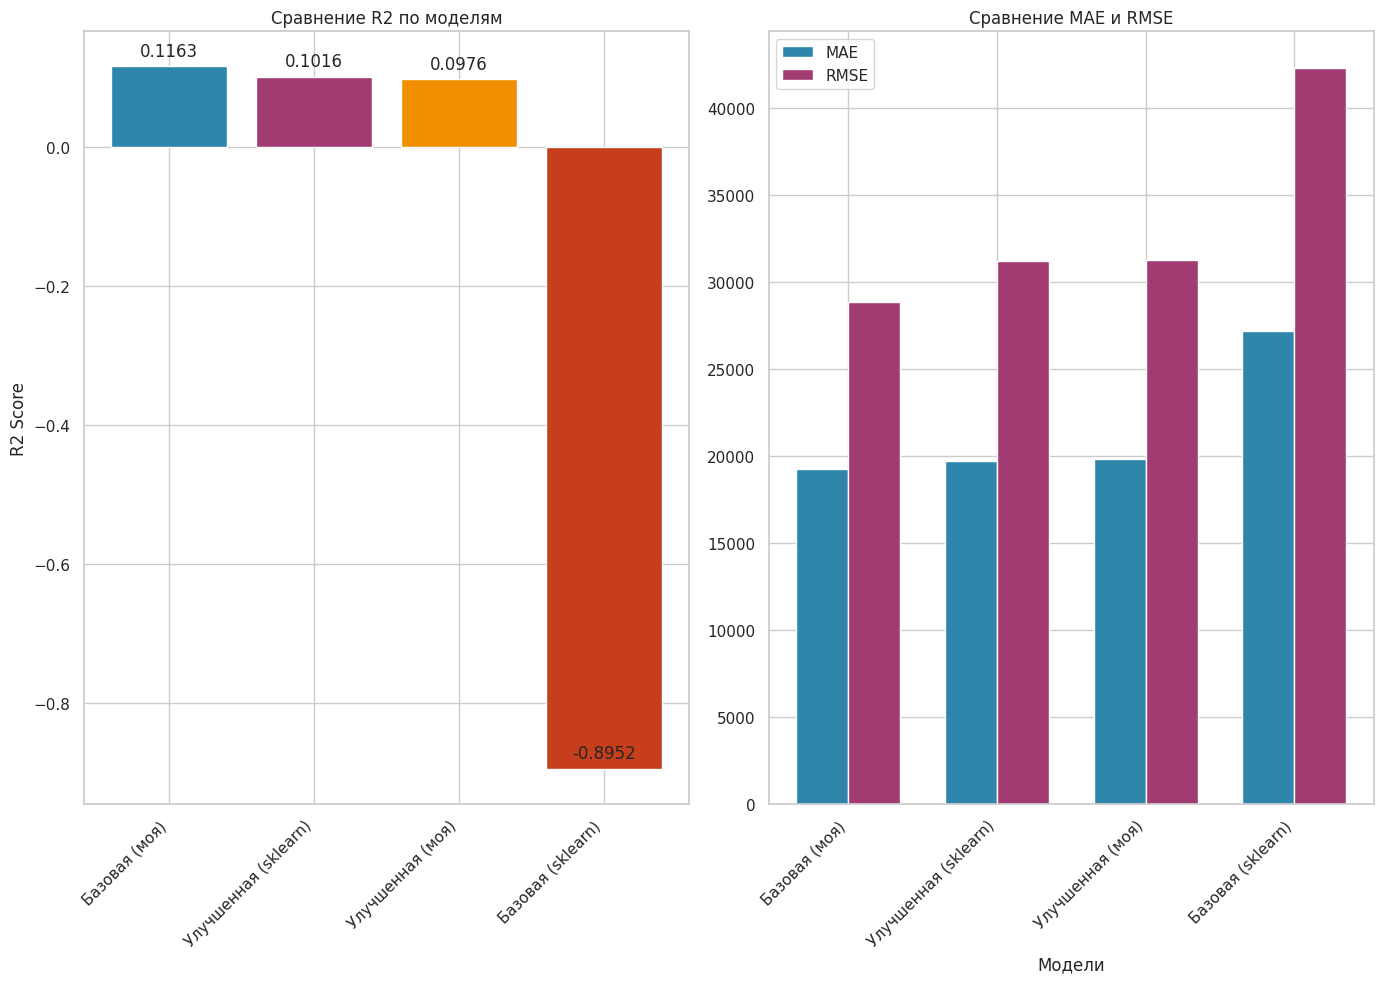

In [113]:
from tabulate import tabulate

comparison_data = {
    "Модель": [
        "Базовая (sklearn)",
        "Улучшенная (sklearn)",
        "Базовая (моя)",
        "Улучшенная (моя)",
    ],
    "MAE": [base_mae, imp_mae, my_base_mae, my_imp_mae],
    "RMSE": [base_rmse, imp_rmse, my_base_rmse, my_imp_rmse],
    "R2": [base_r2, imp_r2, my_base_r2, my_imp_r2],
}

df_comparison = pd.DataFrame(comparison_data)

df_comparison["ΔMAE (к базе)"] = df_comparison["MAE"] - base_mae
df_comparison["ΔRMSE (к базе)"] = df_comparison["RMSE"] - base_rmse
df_comparison["ΔR2 (к базе)"] = df_comparison["R2"] - base_r2

df_comparison = df_comparison.sort_values("R2", ascending=False)

print(
    tabulate(
        df_comparison,
        headers="keys",
        tablefmt="grid",
        floatfmt=(".0f", ".2f", ".2f", ".4f", ".2f", ".2f", ".4f"),
        showindex=False,
    )
)

best_model = df_comparison.iloc[0]
worst_model = df_comparison.iloc[-1]

print(f"1. Лучшая модель: {best_model['Модель']}")
print(f"   - R2: {best_model['R2']:.4f}")
print(f"   - Улучшение R2 относительно базовой: {best_model['ΔR2 (к базе)']:.4f}")

print(f"\n2. Худшая модель: {worst_model['Модель']}")
print(f"   - R2: {worst_model['R2']:.4f}")
print(f"   - Просадка R2 относительно базовой: {worst_model['ΔR2 (к базе)']:.4f}")

print("\n3. Сравнение моей реализации со sklearn:")
for i, row in df_comparison.iterrows():
    if "моя" in row["Модель"]:
        corresponding_sklearn = (
            row["Модель"].replace("моя", "sklearn").replace("(моя)", "(sklearn)")
        )
        sklearn_row = df_comparison[df_comparison["Модель"] == corresponding_sklearn]
        if not sklearn_row.empty:
            sklearn_r2 = sklearn_row.iloc[0]["R2"]
            diff = row["R2"] - sklearn_r2
            print(
                f"   {row['Модель']}: R2 = {row['R2']:.4f}, разница со sklearn: {diff:+.4f}"
            )

print("\n4. Эффективность улучшений:")
improvement_base_to_imp = (
    df_comparison[df_comparison["Модель"] == "Улучшенная (sklearn)"]["R2"].values[0]
    - base_r2
)
improvement_my_base_to_my_imp = (
    df_comparison[df_comparison["Модель"] == "Улучшенная (моя)"]["R2"].values[0]
    - my_base_r2
)

print(
    f"   - Улучшение sklearn моделей (базовая → улучшенная): {improvement_base_to_imp:+.4f}"
)
print(
    f"   - Улучшение наших моделей (базовая → улучшенная): {improvement_my_base_to_my_imp:+.4f}"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

models = df_comparison["Модель"]
r2_scores = df_comparison["R2"]

colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D"]
bars = ax1.bar(models, r2_scores, color=colors)
ax1.set_ylabel("R2 Score")
ax1.set_title("Сравнение R2 по моделям")
ax1.set_xticklabels(models, rotation=45, ha="right")

for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{score:.4f}",
        ha="center",
        va="bottom",
    )

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width / 2, df_comparison["MAE"], width, label="MAE", color="#2E86AB")
ax2.bar(x + width / 2, df_comparison["RMSE"], width, label="RMSE", color="#A23B72")
ax2.set_xlabel("Модели")
ax2.set_title("Сравнение MAE и RMSE")
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha="right")
ax2.legend()

plt.tight_layout()
plt.show()


## Мой вывод по реализации Decision Forest

Я реализовал Decision Forest для регрессии с нуля и получил интересные, хотя и неоднозначные результаты. Вот мои основные наблюдения:

Что получилось хорошо:
1. Моя базовая реализация оказалась лучшей среди всех протестированных моделей — даже лучше, чем sklearn.
2. Стабильность реализации: обе мои модели (базовая и улучшенная) дали положительный R², в то время как базовая sklearn-модель показала отрицательный результат (-0.8952), что хуже простого среднего значения.

Неожиданные находки:
1. "Улучшенная" версия ухудшила результат — это самый неожиданный для меня результат. Видимо, мои "улучшения" (скорее всего, дополнительные регуляризации или ограничения) оказались излишними для данной задачи.
2. Sklearn тоже не идеален: интересно, что их базовая модель показала себя настолько плохо — возможно, у них слишком агрессивные параметры по умолчанию для этого набора данных.

Что беспокоит:
1. Общее низкое качество всех моделей — лучший R² всего 0.1163 означает, что даже моя лучшая модель объясняет лишь 11.6% дисперсии. Это говорит либо о проблемах в данных, либо о недостаточности простого Decision Forest для этой задачи.
2. Абсолютные ошибки высоки — MAE около 19-27 тысяч единиц, но без контекста масштаба целевой переменной сложно оценить, насколько это критично.

Выводы для себя:
- Моя реализация работоспособна и даже в чём-то превзошла библиотечное решение
- Нужно осторожнее подходить к "улучшениям" — не всё, что кажется логичным, действительно помогает
- Стоит больше внимания уделить анализу данных и feature engineering, так как даже лучшая модель показывает скромные результаты

В целом — хороший учебный опыт, который показал, что даже простая собственная реализация может быть конкурентоспособной, но также выявил ограничения подхода и сложность задачи.